# PAI CA1 Group 7 EDA

### Importing Libaries

In [2]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Loading Dataset

In [3]:
%%time
dataset = pd.read_csv('./dataset/taxi_data.csv')
dataset

CPU times: total: 11 s
Wall time: 11.4 s


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.00,143.3,-1.706,-9.271,-1.209,-0.0290,-0.0327,0.0154,2.0,0.00,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
1,0,8.00,143.3,-1.417,-9.548,-1.861,-0.0224,0.0050,-0.0258,3.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
2,0,8.00,143.3,-0.347,-9.533,-1.205,0.0150,-0.0500,0.0251,9.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
3,0,8.00,143.3,-0.601,-9.452,-2.158,0.0045,-0.0117,-0.0041,11.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
4,0,8.00,143.3,-0.598,-9.863,-1.673,-0.0004,0.0003,-0.0098,12.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346547,996432412828,3.71,87.0,-1.908,8.988,2.710,-0.1054,0.4425,0.0588,1538.0,3.57,420,1,Ringo Wegenen,9,Male,Toyota,3.9,49,11
7346548,996432412828,3.65,64.0,-0.910,8.722,2.320,-0.1207,0.3325,0.0899,1539.0,2.98,420,1,Ringo Wegenen,9,Male,Toyota,3.9,49,11
7346549,996432412828,3.46,42.0,-2.490,9.491,-0.503,0.0614,0.3270,0.0429,1540.0,2.39,420,1,Ringo Wegenen,9,Male,Toyota,3.9,49,11
7346550,996432412828,3.62,3.0,-1.499,10.147,-0.668,0.1353,0.2433,0.0930,1542.0,3.79,420,1,Ringo Wegenen,9,Male,Toyota,3.9,49,11


In [4]:
dataset.shape

(7346552, 20)

#### Double Checking whether there is any NULL or missing values

In [5]:
print(dataset.isna().sum())
print(dataset.isnull().sum())


bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
speed             0
driver_id         0
label             0
driver_name       0
years_of_exp      0
gender            0
car_brand         0
driver_rating     0
age               0
age_of_car        0
dtype: int64
bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
speed             0
driver_id         0
label             0
driver_name       0
years_of_exp      0
gender            0
car_brand         0
driver_rating     0
age               0
age_of_car        0
dtype: int64


In [6]:
dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7346552 entries, 0 to 7346551
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bookingID       int64  
 1   Accuracy        float64
 2   Bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  speed           float64
 11  driver_id       int64  
 12  label           int64  
 13  driver_name     object 
 14  years_of_exp    int64  
 15  gender          object 
 16  car_brand       object 
 17  driver_rating   float64
 18  age             int64  
 19  age_of_car      int64  
dtypes: float64(11), int64(6), object(3)
memory usage: 2.3 GB


We can see that our memory load for our pandas dataframe is at 2.3GB, so we are going to shrink the memory load using some techniques

In [7]:
convert_dict = {
    'bookingID': 'int64',
    'Accuracy': 'float16',
    'Bearing': 'float16',
    'acceleration_x': 'float16',
    'acceleration_y': 'float16',
    'acceleration_z': 'float16',
    'gyro_x': 'float16',
    'gyro_y': 'float16',
    'gyro_z': 'float16',
    'second': 'float16',
    'speed': 'float16',
    'driver_id': 'int32',
    'label': 'category',
    'gender': 'category',
    'years_of_exp': 'int16',
    'driver_rating': 'float16',
    'age': 'int16',
    'age_of_car': 'int16'
}

# Convert the columns to the specified types
dataset_new = dataset.astype(convert_dict)
dataset_new.info(memory_usage='deep')

c:\Users\admin\miniconda3\envs\tf\lib\site-packages\pandas\core\dtypes\astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7346552 entries, 0 to 7346551
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   bookingID       int64   
 1   Accuracy        float16 
 2   Bearing         float16 
 3   acceleration_x  float16 
 4   acceleration_y  float16 
 5   acceleration_z  float16 
 6   gyro_x          float16 
 7   gyro_y          float16 
 8   gyro_z          float16 
 9   second          float16 
 10  speed           float16 
 11  driver_id       int32   
 12  label           category
 13  driver_name     object  
 14  years_of_exp    int16   
 15  gender          category
 16  car_brand       object  
 17  driver_rating   float16 
 18  age             int16   
 19  age_of_car      int16   
dtypes: category(2), float16(11), int16(3), int32(1), int64(1), object(2)
memory usage: 1.2 GB


We have successfully shrunked our memory by around 1GB.

In [8]:
dataset_new.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.0,143.25,-1.706055,-9.273438,-1.208984,-0.029007,-0.032715,0.015404,2.0,0.00000,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
1,0,8.0,143.25,-1.416992,-9.546875,-1.861328,-0.022400,0.005001,-0.025803,3.0,0.22998,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
2,0,8.0,143.25,-0.346924,-9.531250,-1.205078,0.014999,-0.049988,0.025101,9.0,0.22998,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
3,0,8.0,143.25,-0.601074,-9.453125,-2.158203,0.004501,-0.011703,-0.004101,11.0,0.22998,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
4,0,8.0,143.25,-0.598145,-9.859375,-1.672852,-0.000400,0.000300,-0.009804,12.0,0.22998,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20


In [19]:
dataset_new['years_of_exp'].min()

5

### Frequency of Cateogorical Variables

In [9]:
category_columns = dataset_new.select_dtypes(include=['category','object']).columns
for columns  in category_columns:
    print(dataset_new[columns].value_counts())
    print('\n')

label
0    5100644
1    2245908
Name: count, dtype: int64


driver_name
Valera Greenall      23899
Ringo Wegenen        23233
Burr Northill        23144
Cherrita Meeke       22428
Wynn Lehrmann        22102
                     ...  
Annmaria Shivlin      9211
Burton Leaney         8874
Maurits Jerrim        8801
Eda Oxley             8764
Eleanor Bernocchi     7405
Name: count, Length: 500, dtype: int64


gender
Male      3766586
Female    3579966
Name: count, dtype: int64


car_brand
Toyota           867756
Volkswagen       698877
Lexus            688205
Audi             649046
BMW              648194
Hyundai          629957
Kia              565814
Mazda            564949
Honda            543196
Mercedes-Benz    512152
Mitsubishi       493039
Nissan           485367
Name: count, dtype: int64




Observations
- Driver Valera Greenall has the most amount of driver_name's occurances, this suggests that either Valera Greenall has taken alot of bookings or there are more booking records per ride in her case. While Eleanor Bernocchi has the least amount of driver_name's occurances.
- Toyota seems to be the most prefered car for most drivers, while Nissan seems to be the least perferred
- There is a slightly skewed distribution of gender, with males being around 100k more.

In [10]:
dataset_new['bookingID'].value_counts()

bookingID
438086664371     3456
1374389534819    2057
34359738469      1957
1108101562533    1826
747324309632     1718
                 ... 
1288490188932      47
1322849927281      47
850403524704       46
893353197740       45
317827579936       43
Name: count, Length: 20000, dtype: int64

Observations:
- There are is large difference in amount of records for each bookingID, this could be attributed to the duration of the ride and the accuracy of the sensors recording the data.

### Target Label

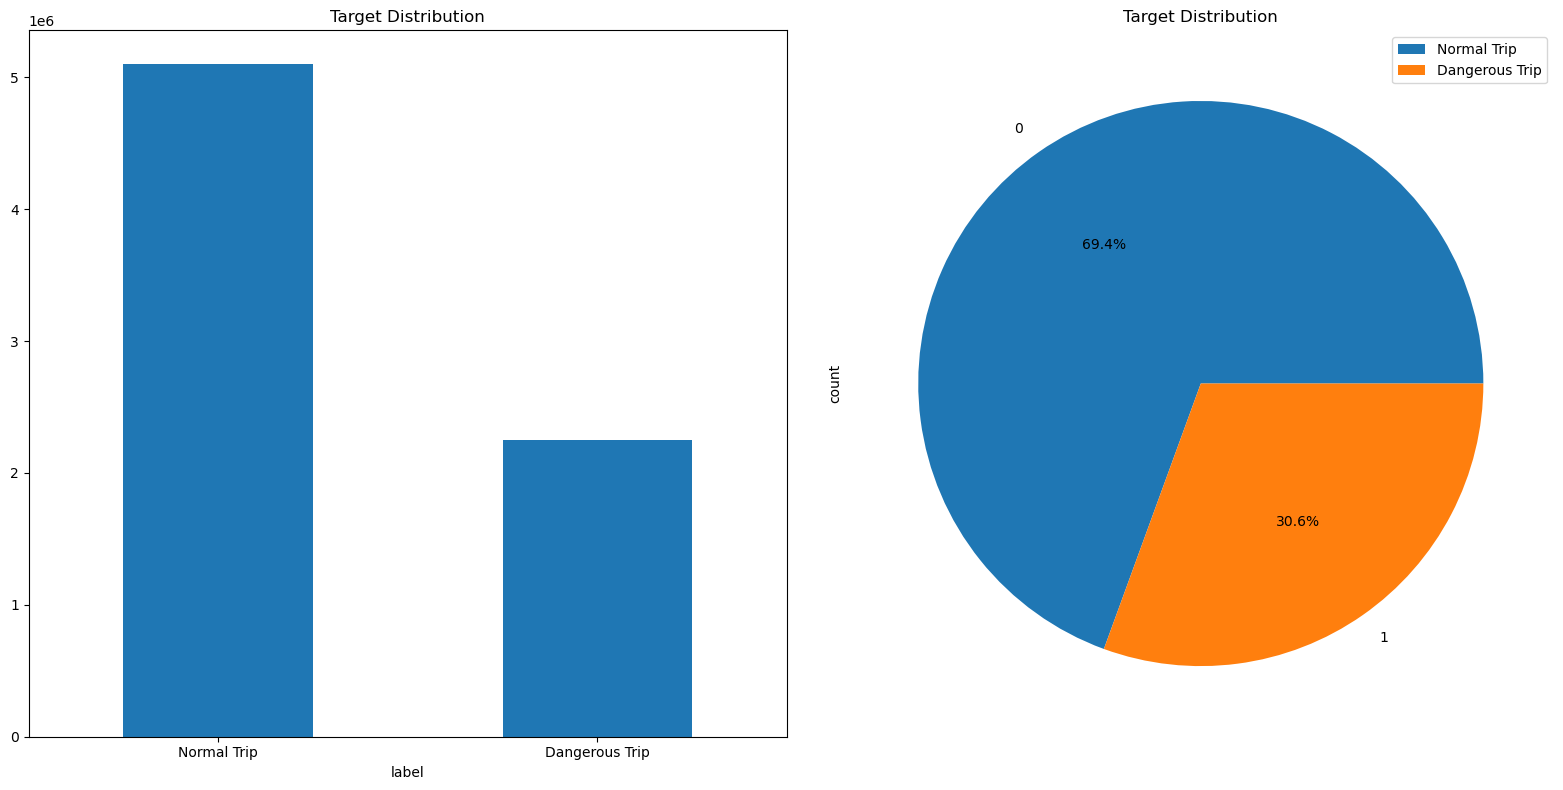

In [11]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 8))

dataset_new["label"].value_counts().plot(kind='bar', ax=ax, title="Target Distribution")
ax.set_xticklabels(('Normal Trip','Dangerous Trip'), rotation=360)

dataset_new["label"].value_counts().plot(kind='pie', ax=ax1, title="Target Distribution", autopct='%1.1f%%')
ax1.legend(('Normal Trip','Dangerous Trip'))

plt.tight_layout()
plt.show()

Observations:
-  Our dataset is imbalance, with Dangerous Trips (labelled : 1) having half the amount as Normal trips. This suggests that we may need to use oversampling techniques for our dataset when building a machine learning model.
- This class imbalance is a good thing for the company, as it shows its drivers as generally careful in their driving. With 30.6% of it being dangerous

### Correlation Matrix

In [12]:
dataset_new

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.000000,143.25,-1.706055,-9.273438,-1.208984,-0.029007,-0.032715,0.015404,2.0,0.000000,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
1,0,8.000000,143.25,-1.416992,-9.546875,-1.861328,-0.022400,0.005001,-0.025803,3.0,0.229980,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
2,0,8.000000,143.25,-0.346924,-9.531250,-1.205078,0.014999,-0.049988,0.025101,9.0,0.229980,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
3,0,8.000000,143.25,-0.601074,-9.453125,-2.158203,0.004501,-0.011703,-0.004101,11.0,0.229980,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
4,0,8.000000,143.25,-0.598145,-9.859375,-1.672852,-0.000400,0.000300,-0.009804,12.0,0.229980,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346547,996432412828,3.710938,87.00,-1.908203,8.984375,2.710938,-0.105408,0.442383,0.058807,1538.0,3.570312,420,1,Ringo Wegenen,9,Male,Toyota,3.900391,49,11
7346548,996432412828,3.650391,64.00,-0.910156,8.718750,2.320312,-0.120728,0.332520,0.089905,1539.0,2.980469,420,1,Ringo Wegenen,9,Male,Toyota,3.900391,49,11
7346549,996432412828,3.460938,42.00,-2.490234,9.492188,-0.502930,0.061401,0.326904,0.042908,1540.0,2.390625,420,1,Ringo Wegenen,9,Male,Toyota,3.900391,49,11
7346550,996432412828,3.619141,3.00,-1.499023,10.148438,-0.667969,0.135254,0.243286,0.093018,1542.0,3.789062,420,1,Ringo Wegenen,9,Male,Toyota,3.900391,49,11


Observations:
- There is not much correlation between any of our continous variables

In [16]:
dataset_new

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.000000,143.25,-1.706055,-9.273438,-1.208984,-0.029007,-0.032715,0.015404,2.0,0.000000,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
1,0,8.000000,143.25,-1.416992,-9.546875,-1.861328,-0.022400,0.005001,-0.025803,3.0,0.229980,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
2,0,8.000000,143.25,-0.346924,-9.531250,-1.205078,0.014999,-0.049988,0.025101,9.0,0.229980,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
3,0,8.000000,143.25,-0.601074,-9.453125,-2.158203,0.004501,-0.011703,-0.004101,11.0,0.229980,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
4,0,8.000000,143.25,-0.598145,-9.859375,-1.672852,-0.000400,0.000300,-0.009804,12.0,0.229980,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.699219,53,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346547,996432412828,3.710938,87.00,-1.908203,8.984375,2.710938,-0.105408,0.442383,0.058807,1538.0,3.570312,420,1,Ringo Wegenen,9,Male,Toyota,3.900391,49,11
7346548,996432412828,3.650391,64.00,-0.910156,8.718750,2.320312,-0.120728,0.332520,0.089905,1539.0,2.980469,420,1,Ringo Wegenen,9,Male,Toyota,3.900391,49,11
7346549,996432412828,3.460938,42.00,-2.490234,9.492188,-0.502930,0.061401,0.326904,0.042908,1540.0,2.390625,420,1,Ringo Wegenen,9,Male,Toyota,3.900391,49,11
7346550,996432412828,3.619141,3.00,-1.499023,10.148438,-0.667969,0.135254,0.243286,0.093018,1542.0,3.789062,420,1,Ringo Wegenen,9,Male,Toyota,3.900391,49,11


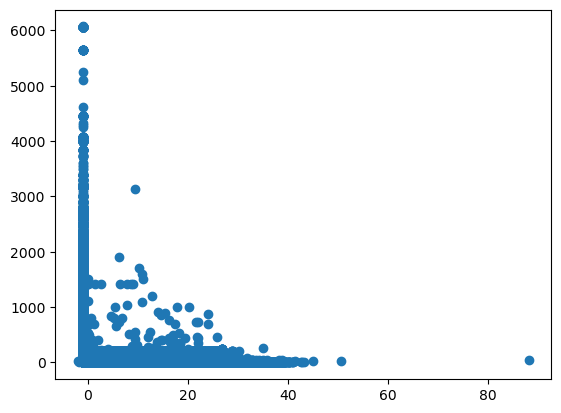

In [17]:
plt.scatter(dataset_new['speed'], dataset_new['Accuracy'])
plt.show()

In [15]:
# sns.pairplot(correlationDf, hue='label', palette='Set1')
# plt.show()